## Compare if we get more information from which columns


In [3]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
import tqdm
from sklearn.metrics import mean_squared_error as mse

In [4]:
n = 10000
J = 6
I = 5

In [5]:
def percentage_fifth_column_is_better(df):
    # requires numpy arrays
    treat = df["true_treatment"]
    fifth = df["fifth"]
    temp = df.drop(["true_treatment", "fifth", "sixth"], axis = 1)
    
    dev_fifth = np.abs(fifth - treat)
    def dev(x):
        deviation = np.abs(x - treat)
        return np.sum(dev_fifth < deviation)/len(dev_fifth)
    print("Percentage the fifth column is better than: ")
    return temp.apply(dev, axis = 0)
    

## 3 modes: 1. No Enforcement of Zeors, 2 enforcement of only pre treatment controlls, 3 enforcement of assumed known DAG

By construction of the DAG the true mixing matrix is already lower triangular


### Mode 1 No Enforcement of Zeors

In [4]:
def sim(mode, B, iter):
    B = B
    df = pd.DataFrame(data = np.zeros((B, 7)), columns=["true_treatment", "first", "second", "third", "fourth", "fifth", "sixth"])
    # fifth should correspond to the true treatment
    data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
    for i in tqdm.tqdm(range(B)):
        data.generate_data(n,I, J, random_state=i)
        est = CausalVarEM(update_sigma=False, true_A=None, max_iter = iter, random_seed= i, mode=mode)
        est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
        df.iloc[i, 0] = data.treatment_effect
        df.iloc[i, 1:] =  est.A[-1,:]
    return df


def metrics(df):
    # mse for all columns
    true_treatment = df["true_treatment"]
    for i in range(1,6):
        mse_column = mse(true_treatment, df.iloc[:,i])
        print("MSE for column " + str(i) + " is " + str(mse_column))
        print("Standard deviation for column " + str(i) + " is " + str(np.std(df.iloc[:,i])))

In [17]:
df = sim("each", 100, 100)
df.to_csv("results/CausalVarEM_each_all_columns.csv", index=False)


100%|██████████| 100/100 [37:20<00:00, 22.40s/it]


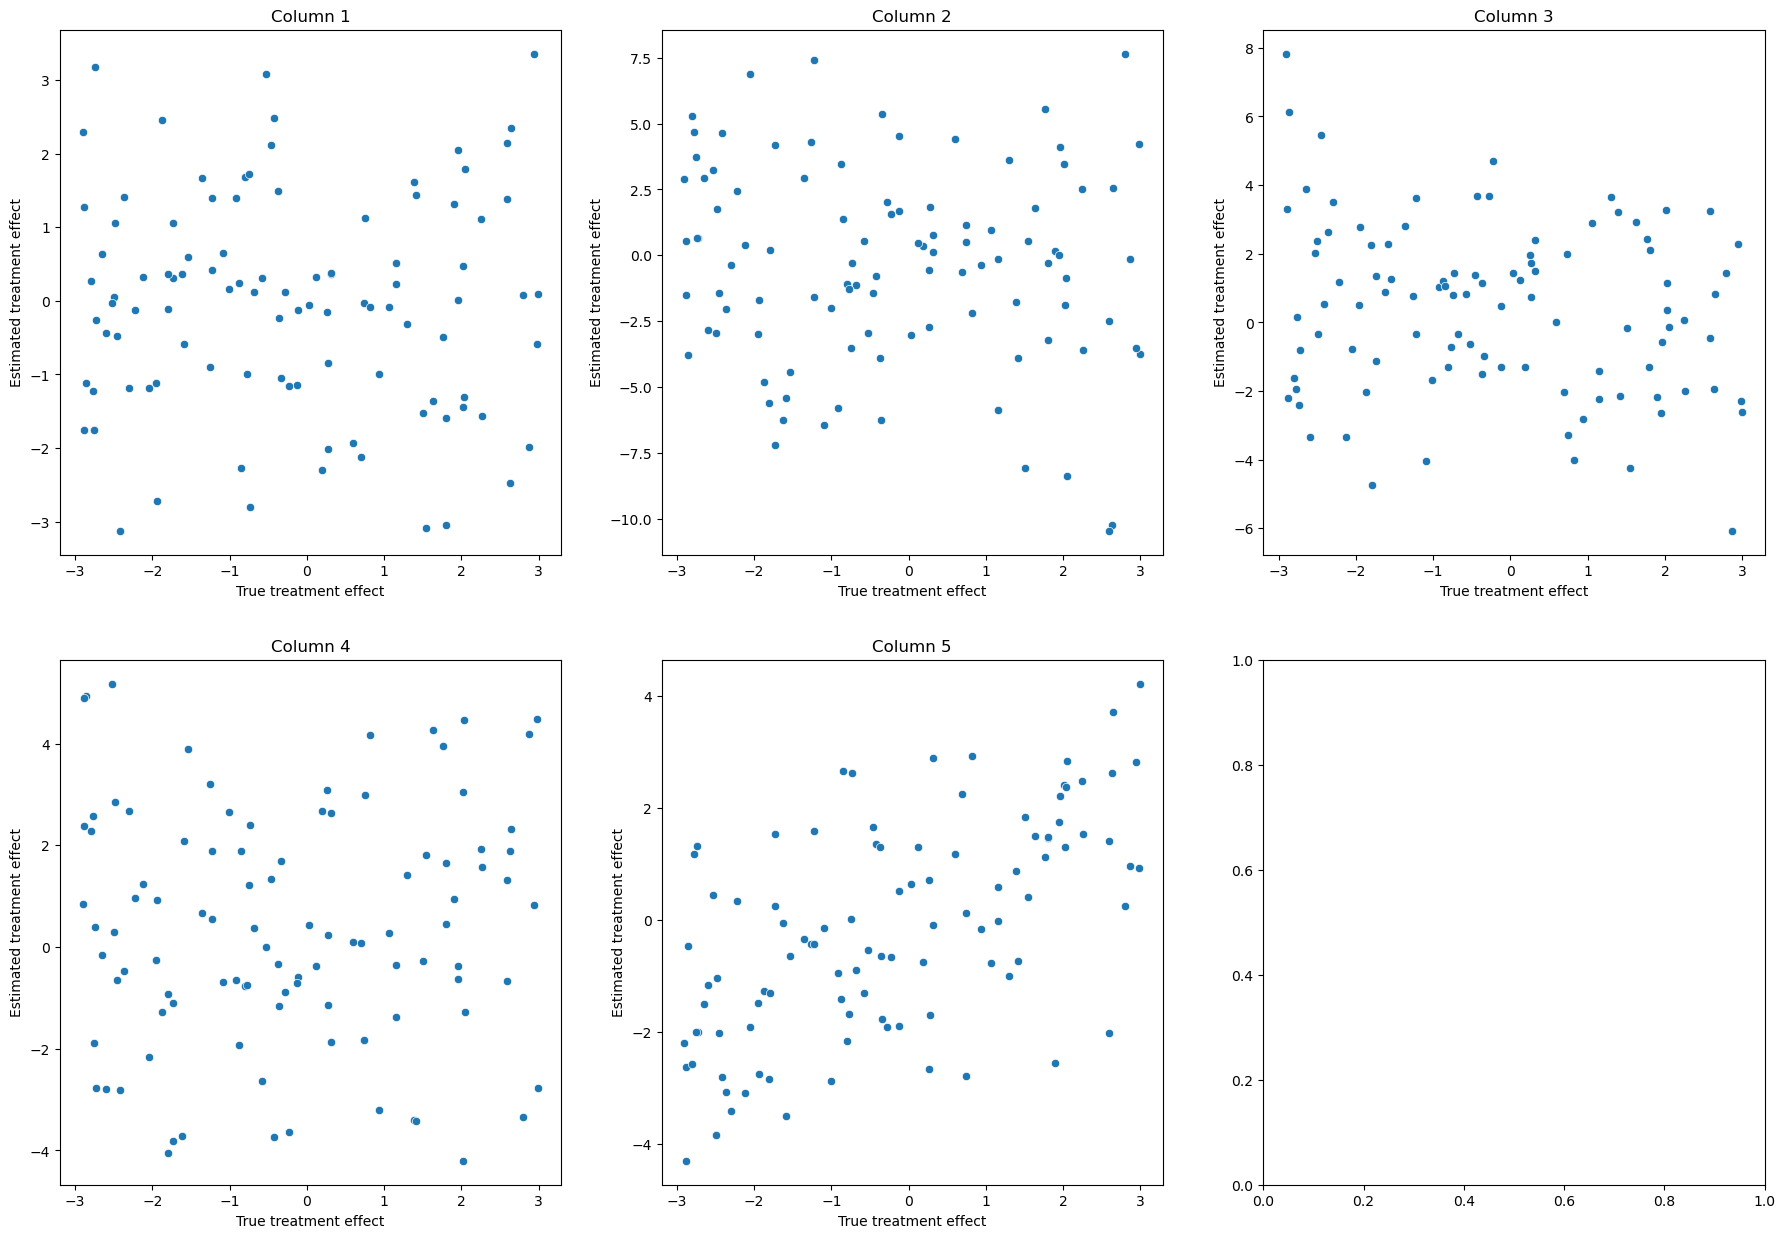

In [26]:
df = pd.read_csv("results/CausalVarEM_each_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")


In [27]:
metrics(df)

MSE for column 1 is 5.506085637668949
Standard deviation for column 1 is 1.4700387167853628
MSE for column 2 is 18.931560945505137
Standard deviation for column 2 is 3.7573010694686158
MSE for column 3 is 11.447256943384835
Standard deviation for column 3 is 2.4810259311883316
MSE for column 4 is 8.662083155882065
Standard deviation for column 4 is 2.3265459832392947
MSE for column 5 is 2.7492643608486276
Standard deviation for column 5 is 1.8995353587520662


In [19]:
percentage_fifth_column_is_better(df)

Percentage the fifth column is better than: 


first     0.63
second    0.73
third     0.73
fourth    0.62
dtype: float64

### Mode 2 enforcement of only pre treatment controlls

In [33]:
df = sim("pre_treatment_controlls", 100, 100)
df.to_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv", index=False)


100%|██████████| 100/100 [37:43<00:00, 22.63s/it]


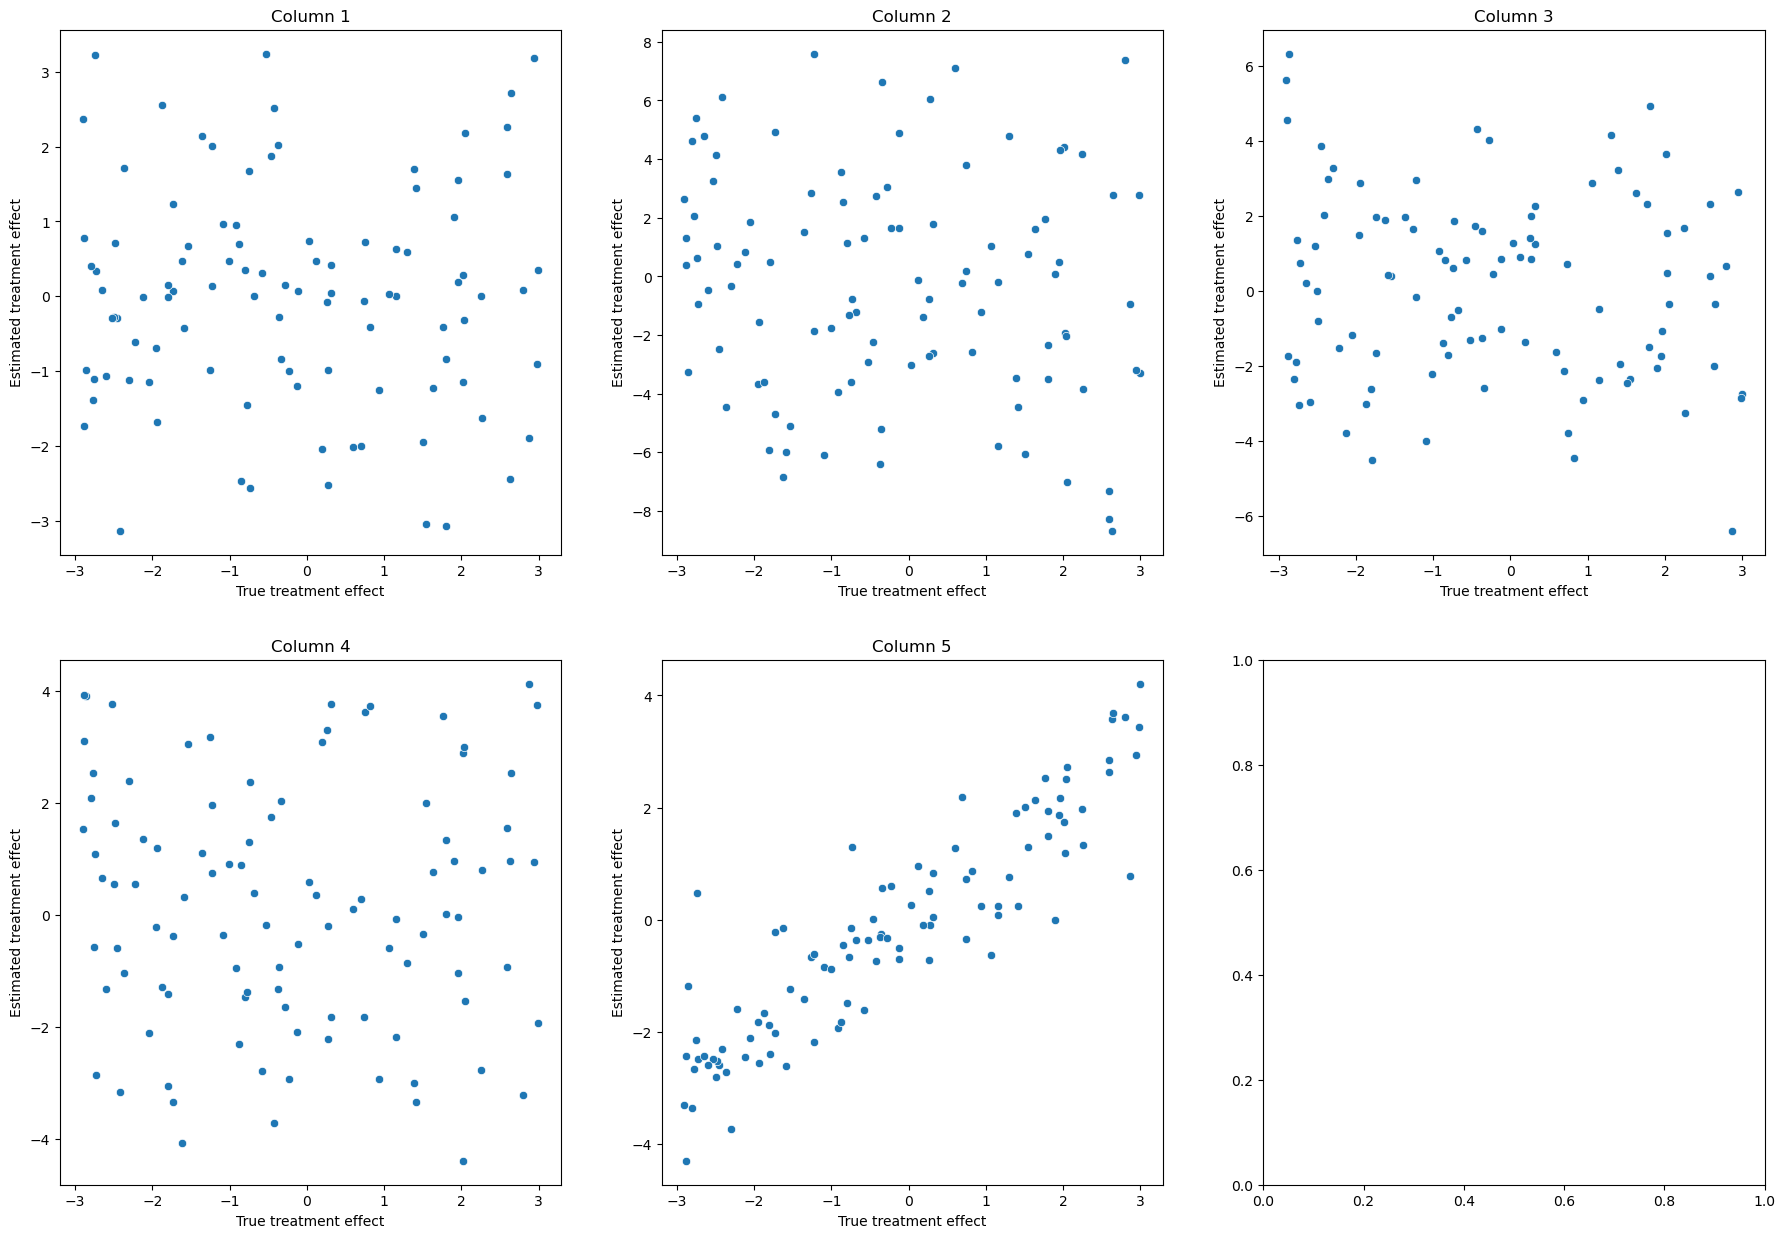

In [28]:
df = pd.read_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")


In [29]:
metrics(df) 

MSE for column 1 is 5.43890388873313
Standard deviation for column 1 is 1.4593073331891628
MSE for column 2 is 19.64005603867503
Standard deviation for column 2 is 3.8056866380119923
MSE for column 3 is 10.597607388896975
Standard deviation for column 3 is 2.4811092339459018
MSE for column 4 is 8.330564846853092
Standard deviation for column 4 is 2.1721918237914526
MSE for column 5 is 0.676631901193408
Standard deviation for column 5 is 1.9102204449111138


In [22]:
percentage_fifth_column_is_better(df)

Percentage the fifth column is better than: 


first     0.79
second    0.87
third     0.89
fourth    0.89
dtype: float64

### 3 enforcement of assumed known DAG

In [63]:
df = sim("lower_triangular", 100, 100)
df.to_csv("results/CausalVarEM_lower_triangular_all_columns.csv", index=False)


100%|██████████| 100/100 [36:55<00:00, 22.15s/it]


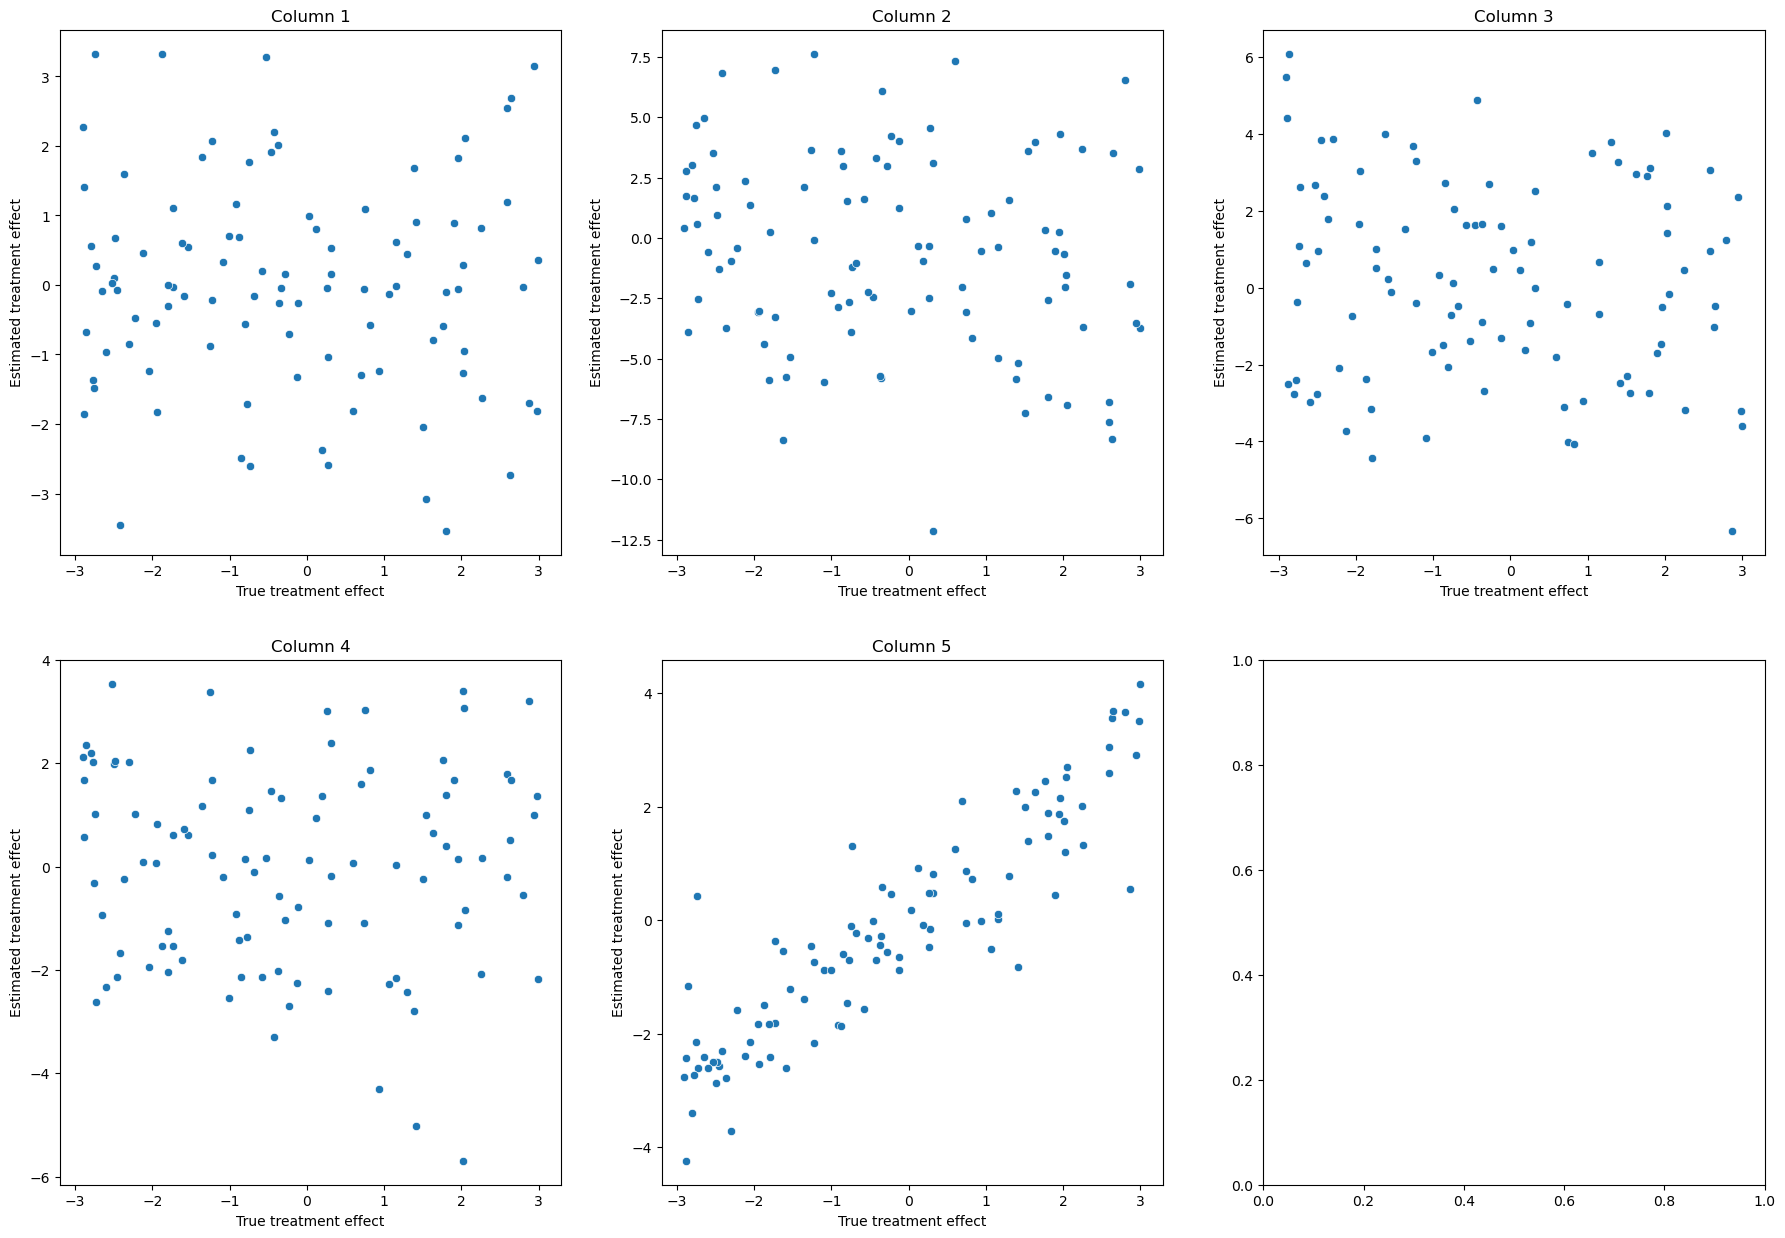

In [30]:
df = pd.read_csv("results/CausalVarEM_lower_triangular_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")

In [25]:
metrics(df) 

MSE for column 1 is 5.703469954902562
Standard deviation for column 1 is 1.5030503303403353
MSE for column 2 is 22.126215083545766
Standard deviation for column 2 is 4.021754471829083
MSE for column 3 is 11.256639106328741
Standard deviation for column 3 is 2.5592953529571503
MSE for column 4 is 7.193790508800998
Standard deviation for column 4 is 1.9176669640492643
MSE for column 5 is 0.6838857418884694
Standard deviation for column 5 is 1.9053152972505087


In [24]:
percentage_fifth_column_is_better(df)

Percentage the fifth column is better than: 


first     0.80
second    0.89
third     0.89
fourth    0.85
dtype: float64

## Better plots

np.float64(-0.21756458573909312)

In [20]:
def vioplot(data, title = ""):
    df = data.copy().drop("sixth", axis = 1)
    df["id"] = range(len(df))
    df_long = df.melt(id_vars = ["id"])
    plt.figure(figsize=(12,5))
    sns.violinplot(data = df_long,x = "variable",  y = "value" , alpha = 0.5)
    plt.xlabel("Column")
    plt.ylabel("Treatment effect")
    plt.title(title)
    plt.ylim((-15,15))
    plt.axhline(y = df["true_treatment"].mean(),  linestyle = "--", c = "b", label = "Mean treatment effect")
    plt.legend()
    plt.show()


def viomae(data):
    treatment = data["true_treatment"]
    df = data.copy().drop(["true_treatment", "sixth"], axis =1)
    maes = df.apply(lambda x: np.abs(x - treatment), axis= 0)
    maes["first"] = np.minimum(np.abs(df["first"] - treatment),np.abs(-df["first"] - treatment))
    maes["id"] = maes.index
    maes_long = maes.melt(id_vars="id")
    plt.figure(figsize=(12,5))
    sns.violinplot(data = maes_long,x = "variable",  y = "value" , alpha = 0.5)
    plt.xlabel("Column")
    plt.ylabel("Absolut deviation from treatment effect")
    plt.axhline(y = 0)
    plt.ylim((-15,15))

    plt.show()





In [21]:
df_no_zeros = pd.read_csv("results/CausalVarEM_each_all_columns.csv")

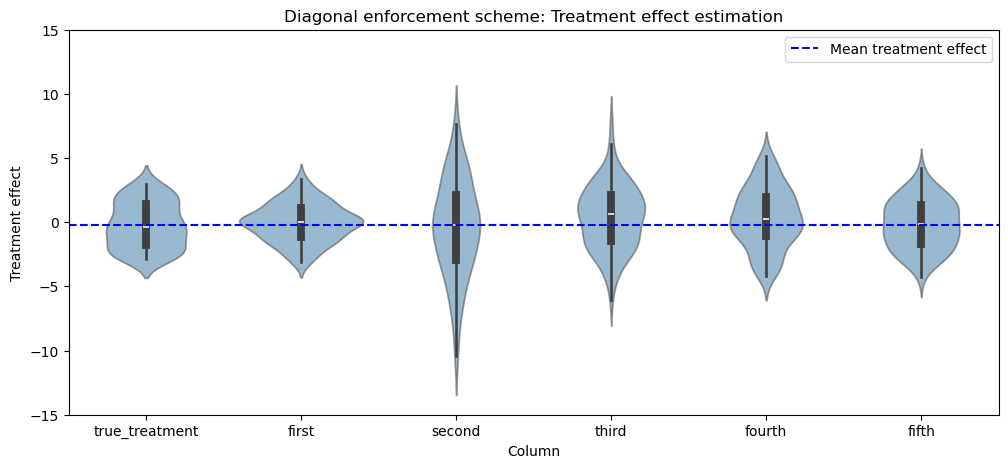

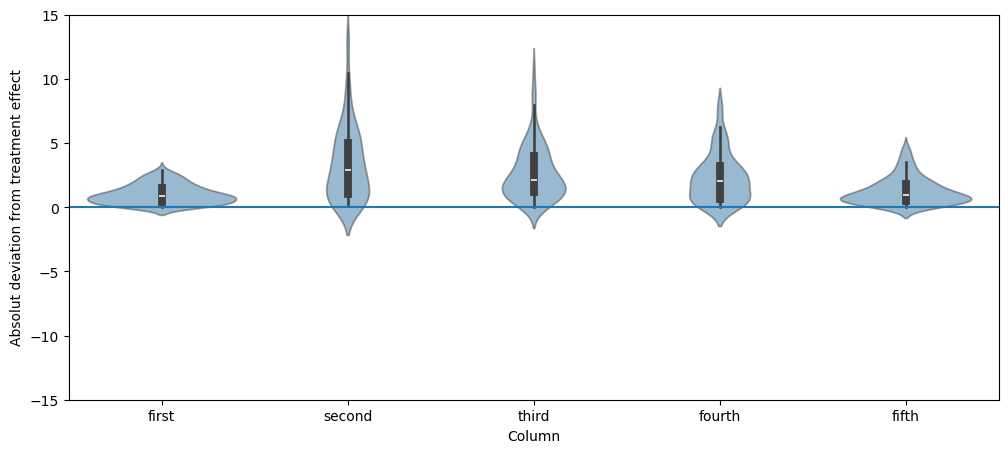

In [22]:
vioplot(df_no_zeros, "Diagonal enforcement scheme: Treatment effect estimation")
viomae(df_no_zeros)


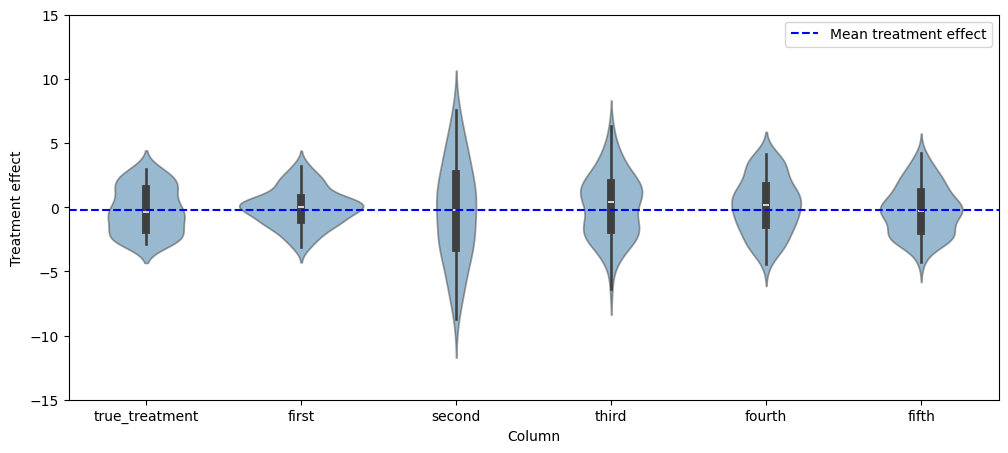

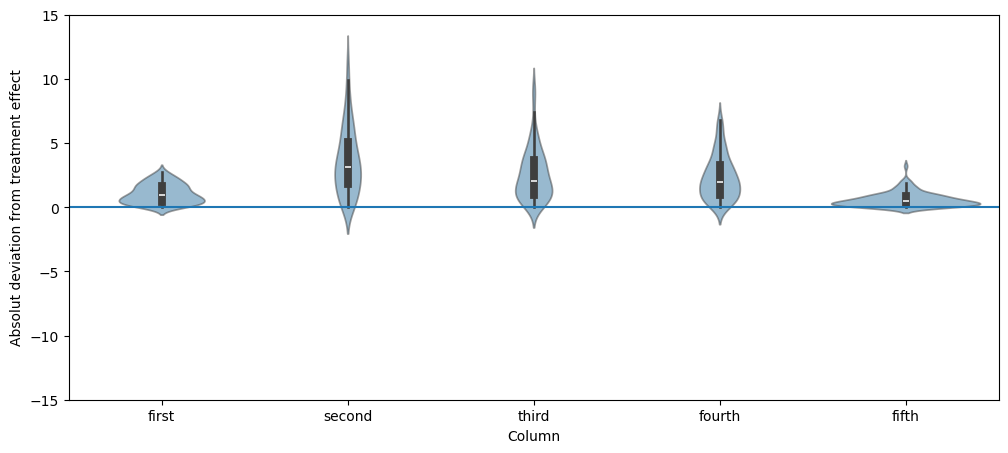

In [23]:
df_pre_treatment_controlls = pd.read_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv")
vioplot(df_pre_treatment_controlls)
viomae(df_pre_treatment_controlls)

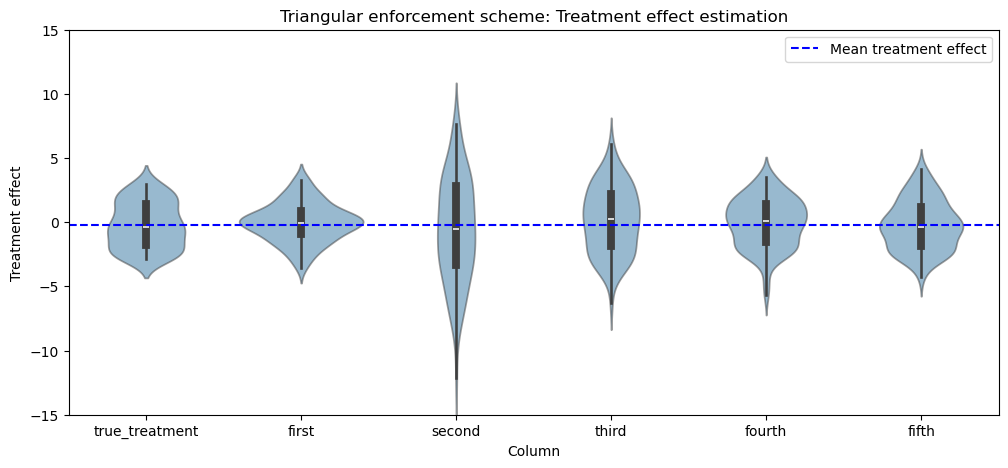

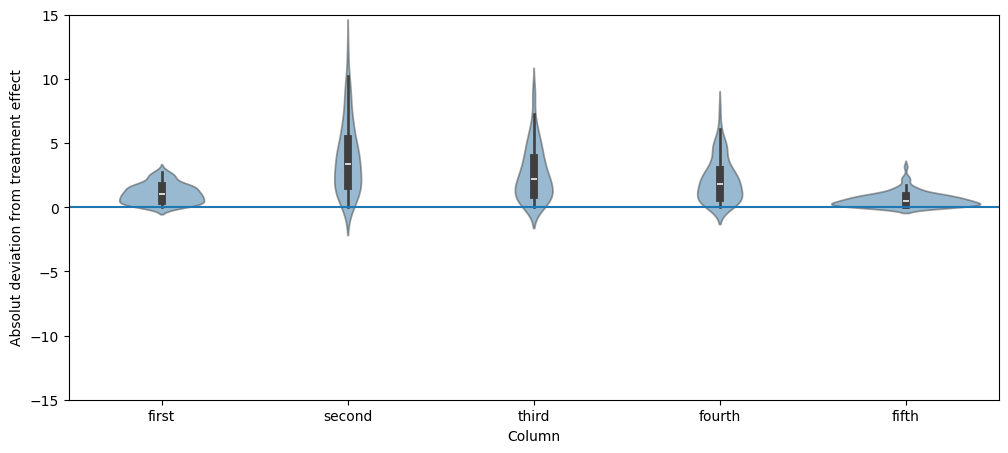

In [24]:
df_lower_triangular = pd.read_csv("results/CausalVarEM_lower_triangular_all_columns.csv")
vioplot(df_lower_triangular,  "Triangular enforcement scheme: Treatment effect estimation")
viomae(df_lower_triangular)